## Imports

In [12]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

## Set random seed for reproducibility


In [13]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

## Dataset

In [ ]:
class MetadataDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.isic_ids = self.data['isic_id']
        self.labels = self.data['target']
        self.features = self.data.drop(columns=['isic_id', 'target']).values.astype(np.float32)

        # Encode labels if they are not already numeric
        if self.labels.dtype != np.int64:
            self.labels = LabelEncoder().fit_transform(self.labels)
        self.labels = self.labels.astype(np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx]), torch.tensor(self.labels[idx])

## Hyperparams

In [ ]:
batch_size = 64
learning_rate = 1e-3
num_epochs = 50
hidden_dim = 128
dropout = 0.5
output_dim = 2  

## Data Loading and Splitting

In [16]:
csv_file = '../data/balanced_data/normalized_metadata.csv'
dataset = MetadataDataset(csv_file)

# Stratified train/validate/test split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



## Architecture Definition

In [17]:
class FeedforwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(FeedforwardNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

## Init

In [ ]:
# Initialize model
input_dim = dataset[0][0].shape[0] 
model = FeedforwardNN(input_dim, hidden_dim, output_dim, dropout)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = model.to(device)

Using device: cuda


## Training

In [ ]:
criterion = nn.CrossEntropyLoss()
model_dir = 'saved_models_1STAR'
best_model_path = os.path.join(model_dir, 'best_model.pth')  

## Eval

In [ ]:
def custom_metric(y_true, y_pred_proba, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.
    """
    y_true = np.array(y_true)
    y_pred_proba = np.array(y_pred_proba)
    
    max_fpr = 1 - min_tpr
    v_gt = abs(y_true - 1)  
    v_pred = 1.0 - y_pred_proba  

    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc

In [ ]:

print(f"Loading best model from: {best_model_path}")
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()
y_true, y_pred, y_pred_proba = [], [], []

test_loss, test_corrects = 0.0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_pred_proba.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())
        test_corrects += torch.sum(preds == labels).item()


test_loss /= len(test_loader.dataset)
test_accuracy = test_corrects / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


print("Test Classification Report:")
print(classification_report(y_true, y_pred))


partial_auc = custom_metric(y_true, y_pred_proba, min_tpr=0.8)
print(f"Partial AUC (pAUC): {partial_auc:.4f}")



Loading best model from: saved_models_1STAR\best_model.pth
Test Loss: 0.3744, Test Accuracy: 0.8442
Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        33
           1       0.94      0.77      0.85        44

    accuracy                           0.84        77
   macro avg       0.85      0.86      0.84        77
weighted avg       0.86      0.84      0.84        77

Partial AUC (pAUC): 0.1355


C:\Users\jonec\AppData\Local\Temp\ipykernel_68724\373108350.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


## Plot

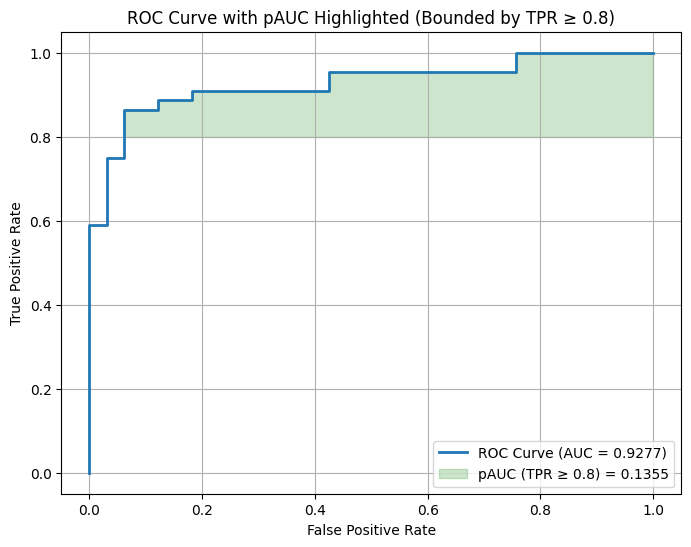

ROC Curve saved at: saved_models_1STAR\roc_curve_with_pauc.png


In [ ]:

fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_true, y_pred_proba):.4f})", linewidth=2)


tpr_threshold = 0.8


fpr_interp = np.interp(tpr_threshold, tpr, fpr)


fpr_bounded = np.concatenate(([fpr_interp], fpr[tpr >= tpr_threshold]))
tpr_bounded = np.concatenate(([tpr_threshold], tpr[tpr >= tpr_threshold]))


plt.fill_between(
    fpr_bounded, 
    tpr_bounded, 
    tpr_threshold, 
    color="green", 
    alpha=0.2, 
    label=f"pAUC (TPR ≥ {tpr_threshold}) = {partial_auc:.4f}"
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with pAUC Highlighted (Bounded by TPR ≥ 0.8)")
plt.legend(loc="lower right")
plt.grid(True)

roc_curve_path = os.path.join(model_dir, "roc_curve_with_pauc.png")
plt.savefig(roc_curve_path, bbox_inches="tight")
plt.show()
print(f"ROC Curve saved at: {roc_curve_path}")